* In this assignment you will be building the **Encoder** part of the Transformer architecture.
* You will be using the **PyTorch** framework to implement the following components
  * Encoder Layer that contains
    * Multi-Head Attention (MHA) Module
    * Position-wise Feed Forward Neural Network

  * Output layer that takes the encoder output and predicts the token_ids.

  * Optionally, study whether adding positional information is helpful.
  
* **DO NOT** USE Built-in **TRANSFORMER LAYERS** as it affects the reproducibility.

* You will be given with a configuration file that contains information on various hyperparameters such as embedding dimension, vocabulary size,number heads and so on

* Use ReLU activation function and Stochastic Gradient Descent optimizer
* Here are a list of helpful Pytorch functions (does not mean you have to use all of them) for this and subsequent assignments
  * [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html#torch-matmul)
  * [torch.bmm](https://pytorch.org/docs/stable/generated/torch.bmm.html)
  * torch.swapdims
  * torch.unsqueeze
  * torch.squeeze
  * torch.argmax
  * [torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
  * [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
  * [torch.nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)
  * torch.nn.Linear
  * torch.nn.LayerNorm
  * torch.nn.ModuleList
  * torch.nn.Sequential
  * [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
  
* Important: **Do not** set any global seeds.

* Helpful resources to get started with

 * [Annotated Transformers](https://nlp.seas.harvard.edu/annotated-transformer/)
 * [PyTorch Source code of Transformer Layer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)



# Import

In [73]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

from  pprint import pprint
from yaml import safe_load
import requests
from io import BytesIO

import math

# Configuration

In [2]:
#do not edit this cell
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/enc_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 10},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [3]:
#do not edit this cell
vocab_size = config['input']['vocab_size']
batch_size = config['input']['batch_size']
seq_len = config['input']['seq_len']
embed_dim = config['input']['embed_dim']

* Here, you are directly given with the token ids
* Assume that length of all sequences are equal to the context length (T) (so that we do not need to bother about padding shorter sequences while batching)

In [4]:
# do not edit this cell
data_url = 'https://github.com/Arunprakash-A/LLM-from-scratch-PyTorch/raw/main/config_files/w1_input_tokens'
r = requests.get(data_url)
token_ids = torch.load(BytesIO(r.content))
print(token_ids)

tensor([[5, 7, 5, 6, 3, 8, 7, 5],
        [7, 2, 7, 1, 2, 1, 1, 7],
        [1, 0, 0, 3, 6, 3, 0, 8],
        [5, 0, 2, 8, 6, 5, 5, 3],
        [3, 5, 4, 8, 5, 0, 7, 3],
        [8, 6, 7, 4, 4, 4, 0, 1],
        [5, 8, 1, 0, 1, 1, 0, 3],
        [1, 7, 8, 8, 0, 5, 3, 7],
        [7, 7, 1, 4, 5, 6, 7, 0],
        [1, 7, 2, 8, 3, 0, 0, 4]])


<ipython-input-4-0fefa6fcf57f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  token_ids = torch.load(BytesIO(r.content))


# Building the sub-layers

In [5]:
# do not edit this cell
dq = torch.tensor(config['model']['dq'])
dk = torch.tensor(config['model']['dk'])
dv = torch.tensor(config['model']['dv'])
dmodel = embed_dim
heads = torch.tensor(config['model']['n_heads'])
d_ff = config['model']['d_ff']

##Multi-Head Attention

 * Be mindful when using `torch.matmul`
 * Ensure that you understood what is being computed (because matrix product is not commutative)
 * Randomly initialize the parameters using normal distribution with the following seed values
  * $W_Q:$(seed=43)
  * $W_K:$(seed=44)
  * $W_V:$(seed=45)
  * $W_O:$(seed=46)

In [59]:
class MHA(nn.Module):

    def __init__(self, dmodel, dq, dk, dv, heads):
        super(MHA, self).__init__()
        # Initialize attributes
        self.dmodel = dmodel
        self.dq = dq
        self.dk = dk
        self.dv = dv
        self.heads = heads

        # Initialize K, Q, V, and O with normal distribution
        torch.manual_seed(43)
        self.WQ = nn.Parameter(torch.randn(dq * heads, dmodel))  # Query matrix
        nn.init.normal_(self.WQ)  # Initialize with normal distribution

        torch.manual_seed(44)
        self.WK = nn.Parameter(torch.randn(dk * heads, dmodel))  # Key matrix
        nn.init.normal_(self.WK)  # Initialize with normal distribution

        torch.manual_seed(45)
        self.WV = nn.Parameter(torch.randn(dv * heads, dmodel))  # Value matrix
        nn.init.normal_(self.WV)  # Initialize with normal distribution

        torch.manual_seed(46)
        self.WO = nn.Parameter(torch.randn(dmodel, dv * heads))  # Output matrix
        nn.init.normal_(self.WO)  # Initialize with normal distribution

    def forward(self, H=None):
      """
        Input: Size [BS x T x dmodel]
        Output: Size [BS x T x dmodel]
      """
      # Compute queries, keys, and values
      Q = torch.matmul(H, self.WQ.T)  # Size: [BS, T, dq * heads]
      K = torch.matmul(H, self.WK.T)  # Size: [BS, T, dk * heads]
      V = torch.matmul(H, self.WV.T)  # Size: [BS, T, dv * heads]

      # Reshape Q, K, V for multi-head attention
      batch_size = Q.shape[0]
      seq_len = Q.shape[1]

      Q = Q.view(batch_size, seq_len, self.heads, self.dq).transpose(1, 2)  # Size: [BS, heads, T, dq]
      K = K.view(batch_size, seq_len, self.heads, self.dk).transpose(1, 2)  # Size: [BS, heads, T, dk]
      V = V.view(batch_size, seq_len, self.heads, self.dv).transpose(1, 2)  # Size: [BS, heads, T, dv]

      # Scaled dot-product attention
      dk = torch.tensor(self.dk, dtype=torch.float32)
      scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(dk)  # Size: [BS, heads, T, T]
      attention = F.softmax(scores, dim=-1)  # Apply softmax along the last dimension

      # Compute the weighted sum of values
      out = torch.matmul(attention, V)  # Size: [BS, heads, T, dv]

      # Concatenate the heads and apply the final linear transformation
      out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.heads * self.dv)  # Size: [BS, T, heads * dv]
      out = torch.matmul(out, self.WO.T)  # Size: [BS, T, dmodel]

      return out


In [60]:
token_ids

tensor([[5, 7, 5, 6, 3, 8, 7, 5],
        [7, 2, 7, 1, 2, 1, 1, 7],
        [1, 0, 0, 3, 6, 3, 0, 8],
        [5, 0, 2, 8, 6, 5, 5, 3],
        [3, 5, 4, 8, 5, 0, 7, 3],
        [8, 6, 7, 4, 4, 4, 0, 1],
        [5, 8, 1, 0, 1, 1, 0, 3],
        [1, 7, 8, 8, 0, 5, 3, 7],
        [7, 7, 1, 4, 5, 6, 7, 0],
        [1, 7, 2, 8, 3, 0, 0, 4]])

In [61]:
# # Dry run
# # Create a random tensor of shape [batch_size, seq_len, d_model]
# mha = MHA(dmodel=8, dq=4, dk=4, dv=4, heads=2)
# input_tensor = torch.rand(2, 2, 8)  # Shape: [BS=2, T=2, d_model=8]

# output = mha(input_tensor)
# print("Output shape:", output.shape)  # Should print: [2, 2, 8]

## Pointwise FFN

* Randomly initialize the parameters using normal distribution with the following seed values
  * $W_{1}:$(seed=47)
  * $W_2:$(seed=48)  

In [62]:
class FFN(nn.Module):
    def __init__(self, dmodel, d_ff, layer=0):
        super(FFN, self).__init__()

        # Define linear layers without bias
        self.layer1 = nn.Linear(dmodel, d_ff, bias=False)
        self.layer2 = nn.Linear(d_ff, dmodel, bias=False)

        # Initialize weights using normal distribution with the specified seed
        torch.manual_seed(47)
        nn.init.normal_(self.layer1.weight)  # Initialize layer1 weights using normal distribution

        torch.manual_seed(48)
        nn.init.normal_(self.layer2.weight)  # Initialize layer2 weights using normal distribution

        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        '''
        input: size [BS, T, dmodel]
        output: size [BS, T, dmodel]
        '''
        # Apply first linear transformation followed by ReLU
        x = self.relu(self.layer1(x))

        # Apply second linear transformation
        out = self.layer2(x)

        return out



## Output Layer

* Randomly initialize the linear layer
 * $W_L:$(seed=49)


In [63]:
class OutputLayer(nn.Module):

  def __init__(self,dmodel,vocab_size):
    super(OutputLayer,self).__init__()
    # your code goes here
    torch.manual_seed(49)
    self.fc1 = nn.Linear(dmodel, vocab_size)

    # # Activation function
    # self.activation = nn.Softmax()

  def forward(self,representations):
    '''
    input: size [bsxTxdmodel]
    output: size [bsxTxvocab_size]
    Note: Do not apply the softmax. Just return the output of linear transformation
    '''
    out = self.fc1(representations)  # [bs, T, vocab_size]
    return out

## Encoder Layer

In [64]:
class EncoderLayer(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,d_ff,heads):
    super(EncoderLayer,self).__init__()
    self.mha = MHA(dmodel,dq,dk,dv,heads)
    self.layer_norm_mha = torch.nn.LayerNorm(dmodel)
    self.layer_norm_ffn = torch.nn.LayerNorm(dmodel)
    self.ffnn = FFN(dmodel,d_ff)

  def forward(self,x):

    # do a forward pass
    # Multi-Head Attention Forward Pass
    attention_output = self.mha(x)  # Output from MHA

    # Residual connection and Layer Norm after MHA
    out = self.layer_norm_mha(x + attention_output)

    # Feed Forward Network Forward Pass
    ffn_output = self.ffnn(out)  # Output from FFN

    # Residual connection and Layer Norm after FFN
    out = self.layer_norm_ffn(out + ffn_output)

    return out

## Model with one encoder layer

 * The encoders' forward function accepts the token_ids as input
 * Generate the embeddings for the token ids by initializing the emebedding weights from normal distribution by setting the seed value to 50
 * Use `torch.nn.Embed()` to generate required embeddings

In [65]:
class Encoder(nn.Module):

  def __init__(self,vocab_size,embed_dim,dq,dk,dv,d_ff,heads,num_layers=1):
    super(Encoder,self).__init__()
    # your code goes here
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    # Initialize the embedding layer
    torch.manual_seed(50)  # Set seed for reproducibility
    self.embedding = nn.Embedding(vocab_size, embed_dim)

    # Initialize the encoder layer
    self.encoder_layer = EncoderLayer(embed_dim, dq, dk, dv, d_ff, heads)

    # Initialize the output layer
    self.output_layer = OutputLayer(embed_dim, vocab_size)

  def forward(self,x):
    '''
    The input should be tokens ids of size [BS,T]
    '''
    out = self.embedding(x)  # get the embeddings of the tokens
    out = self.encoder_layer(out) # pass the embeddings throught the encoder layers
    out = self.output_layer(out) # get the logits

    return out

In [66]:
model = Encoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training the model

 * Train the model for 30 epochs and compute the loss

<ipython-input-59-8156c4cb525e>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)


Epoch 0, Loss: 2.4414265155792236
Epoch 2, Loss: 2.383842945098877
Epoch 4, Loss: 2.333833932876587
Epoch 6, Loss: 2.287980556488037
Epoch 8, Loss: 2.248408794403076
Epoch 10, Loss: 2.2107348442077637
Epoch 12, Loss: 2.1746158599853516
Epoch 14, Loss: 2.1396851539611816
Epoch 16, Loss: 2.1057276725769043
Epoch 18, Loss: 2.072652816772461
Epoch 20, Loss: 2.0403761863708496
Epoch 22, Loss: 2.0088517665863037
Epoch 24, Loss: 1.9780422449111938
Epoch 26, Loss: 1.947906494140625
Epoch 28, Loss: 1.918418288230896


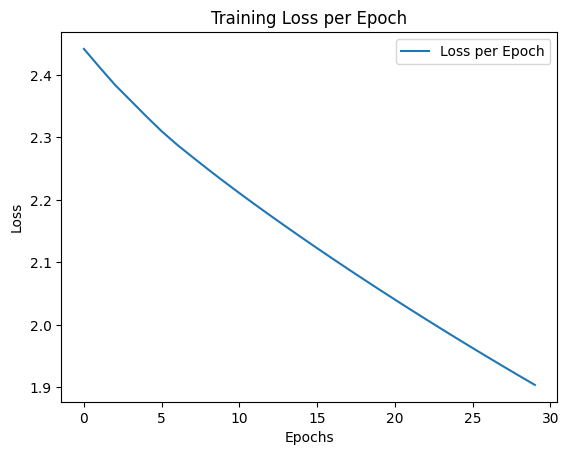

Final Loss after training for 30 epochs is 1.9038957357406616


In [67]:
import matplotlib.pyplot as plt


def train(token_ids, model, optimizer, criterion, epochs=30):
    # List to store loss values
    loss_values = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        # Zero the gradients before the forward pass
        optimizer.zero_grad()

        # Forward pass
        out = model(token_ids)  # Get the model output

        # Reshape output and target for loss calculation
        batch_size, seq_len, vocab_size = out.size()
        out = out.view(-1, vocab_size)  # Flatten output
        target = token_ids.view(-1)  # Flatten token_ids

        # Compute the loss
        loss = criterion(out, target)

        # Store the loss value for visualization
        loss_values.append(loss.item())

        # Print loss for monitoring
        if epoch % 2 == 0:  # Print every 2 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Plot the loss after training
    plt.plot(range(epochs), loss_values, label='Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.show()

    print(f'Final Loss after training for {epoch + 1} epochs is {loss.item()}')

model = Encoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train(token_ids, model, optimizer, criterion, epochs=30)

# Inference

In [68]:
with torch.inference_mode():
  predictions =  model(token_ids) # predict the labels

  # get result obtained from softmax
  predicted_res = predictions.argmax(dim=-1)

correct_predictions = (token_ids == predicted_res)  # Shape: [BS, T]
print(torch.count_nonzero(correct_predictions))  # Counts the number of matches

tensor(42)


<ipython-input-59-8156c4cb525e>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)


* See how many labels are correctly predicted

# I'm getting
- Loss -> 1.9038
- Correct Prediction -> 42

* The loss by now should be about 2.39 and the number of correct predictions should be about 37

# Encoder with N Layers

  * The intialized parameters in all layers are identical
  * use ModuleList to create **deep-copies** of encoder layer

In [69]:
import copy
class Encoder(nn.Module):

  def __init__(self,vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1):
    super(Encoder,self).__init__()
    torch.manual_seed(50)
    self.embed_weights = nn.Embedding(vocab_size,dmodel)

    self.norm = nn.LayerNorm(embed_dim)

    encoder_layer = EncoderLayer(dmodel,dq,dk,dv,d_ff,heads)
    self.enc_layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])

    self.output_layer = OutputLayer(dmodel, vocab_size)

  def forward(self,x):
    '''
    1. Get embeddings
    2. Pass it through encoder layer-1 and recursively pass the output to subsequent enc.layers
    3. output the logits
    '''
    out = self.embed_weights(x)
    for layer in self.enc_layers:
      out = layer(out)
    out = self.output_layer(out)
    return out

* Train the stack of encoder layers with `num_layers=2` for the same 30 epochs

In [70]:
model1 = Encoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01)

<ipython-input-59-8156c4cb525e>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)


Epoch 0, Loss: 2.4108848571777344
Epoch 2, Loss: 2.3011093139648438
Epoch 4, Loss: 2.244187831878662
Epoch 6, Loss: 2.204986095428467
Epoch 8, Loss: 2.17459774017334
Epoch 10, Loss: 2.1440091133117676
Epoch 12, Loss: 2.1163861751556396
Epoch 14, Loss: 2.0909790992736816
Epoch 16, Loss: 2.0691351890563965
Epoch 18, Loss: 2.0486764907836914
Epoch 20, Loss: 2.0316402912139893
Epoch 22, Loss: 2.021076202392578
Epoch 24, Loss: 2.00136399269104
Epoch 26, Loss: 1.9825570583343506
Epoch 28, Loss: 1.9671396017074585


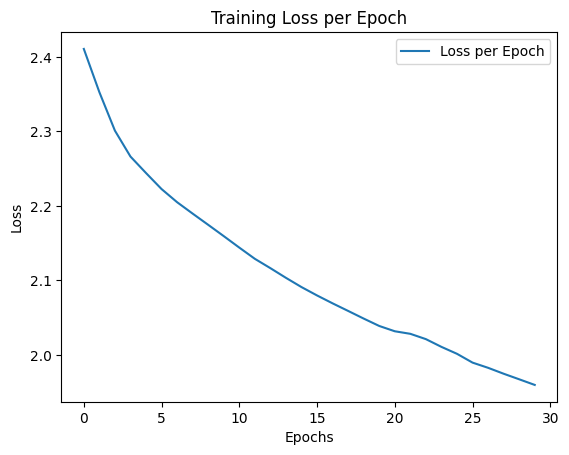

Final Loss after training for 30 epochs is 1.959573745727539


In [71]:
train(token_ids, model1, optimizer, criterion, epochs=30)

In [72]:
with torch.inference_mode():
  predictions = model1(token_ids) # predict labels

  predicted_out = predictions.argmax(dim=-1)

correct_predictions = (token_ids == predicted_out)
print(torch.count_nonzero(correct_predictions))

tensor(25)


<ipython-input-59-8156c4cb525e>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dk = torch.tensor(self.dk, dtype=torch.float32)


In [ ]:
torch.count_nonzero(predictions==token_ids)

# I'm getting
- Loss -> 1.95
- Correct Prediction -> 25

* Now, the loss value should be about 1.9 and the number of correct preditions is about 38

## Count Number of Parameters

In [ ]:
for parameter in model.parameters():
  total_num_parameters = None

print('total number of parameters in the model \n including the embedding layer is:', total_num_parameters)

## (Optional) Positional Encoding

 * We now use the positional embedding as defined in the [paper](https://arxiv.org/pdf/1706.03762v1.pdf) (differs a bit from the lecture).
 * Note that, the positional encoding for each position is fixed (not a learnable parameter)
 * However, we add this with the raw_embeddings which are learnable.
 * Therefore, it is important to create a class definition for PE and register PE parameters in the buffer (in case we move the model to GPU)
 * Just create a matrix of same size of input and add it to the embeddings

In [ ]:
class PositionalEncoding(nn.Module):
    "Positional Encoding using sine and cosine functions."

    def __init__(self, d_model, max_len=8):
        super(PositionalEncoding, self).__init__()

        # Create a matrix to hold positional encodings
        positional_encoding = torch.zeros(max_len, d_model)

        # Position indices (shape: [max_len, 1])
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Dividing terms: 10000^(2i / d_model)
        divisor_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices (2i) and cosine to odd indices (2i+1)
        positional_encoding[:, 0::2] = torch.sin(positions * divisor_term)  # Even indices
        positional_encoding[:, 1::2] = torch.cos(positions * divisor_term)  # Odd indices

        # Register the positional encodings as a buffer (non-trainable)
        self.register_buffer("positional_encoding", positional_encoding.unsqueeze(0))  # Shape: [1, max_len, d_model]

    def forward(self, x):
        # Add positional encoding to the input embeddings (x should be of size [batch_size, seq_len, d_model])
        x = x + self.positional_encoding[:, :x.size(1), :]
        return x
